# Case_study_3_1

Use the linear SVM optimization problem to plot the evolution of $f({\bf{w}}) - f({\bf{w}}*)$ for the subgradient method using constant learning rate and $$\eta_k = \frac{1}{\sqrt{k+1}}$$.

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [12]:
from local.libl.Generation import scenarios_classification
from local.lib.utils import plot_surface, solver_cvx, eval_loss, calculation_subgrad_svm, calculation_subgrad_svm_inst, grad_FOM, grad_FOM_decay, grad_inst, grad_inst_decay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install cvxpy

In [ ]:
import cvxpy as cp

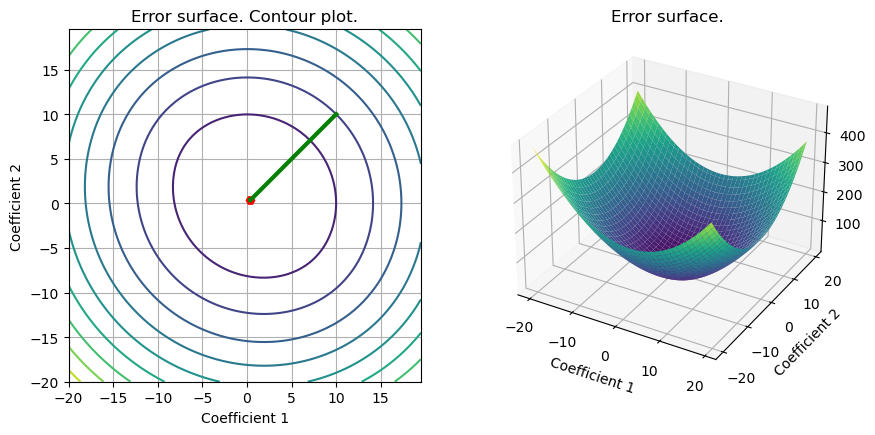

In [13]:
# Loading scenarios
# ===========================
scenario=1
data_class, set_up=scenarios_classification(scenario);

# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.sum(cp.pos(1-cp.multiply(Y,X @ w)))
reg_L2 = lambda w: cp.pnorm(w, p=2)**2
loss_svm_L2 = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + (lambd/2) * reg_L2(w)

subgrad_svm_L2 = calculation_subgrad_svm
subgrad_svm_L2_inst = calculation_subgrad_svm_inst


# Solution of the empirical risk using CVX
#=========================================
w_svm_cvx=solver_cvx(set_up,loss_svm_L2)

w = cp.Variable(w_svm_cvx.shape[0])
w.value = w_svm_cvx                     
loss_opt=loss_svm_L2(set_up['Niter_train'],set_up['Xtrain'][:,:set_up['d']+1],set_up['ytrain'][:,0],w,set_up['Lambda']).value

# Subgradient descent
out_subgd = grad_FOM(set_up,subgrad_svm_L2)
out_subgd_decay = grad_FOM_decay(set_up,subgrad_svm_L2)

S = plot_surface(set_up,loss_svm_L2,w_svm_cvx,include_grad=True,grad=out_subgd)

loss_subgrad=eval_loss(out_subgd,set_up,loss_svm_L2)
loss_subgrad_decay=eval_loss(out_subgd_decay,set_up,loss_svm_L2)


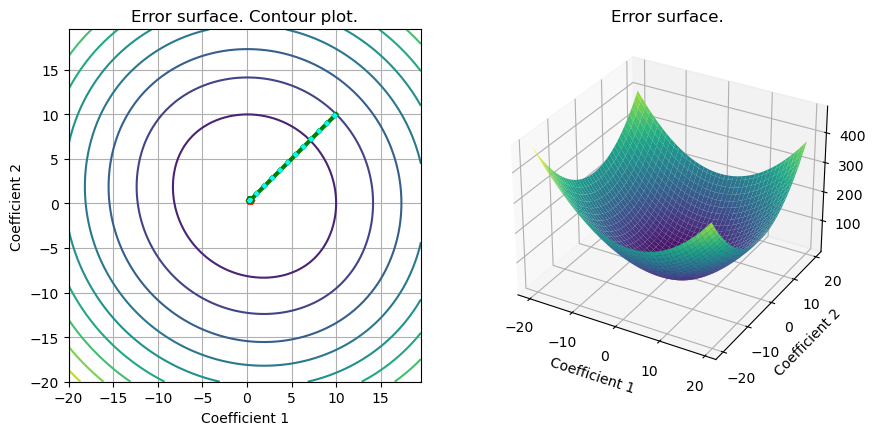

In [14]:
# Stochastic gradient descent (several realizations). Comparison with GD and Newton)
loss_inst=np.zeros((set_up['Number_tests'],set_up['Niter_train']));
loss_inst_decay=np.zeros((set_up['Number_tests'],set_up['Niter_train']));

out_g = np.zeros((2*set_up['Number_tests']+1,set_up['d']+1,set_up['Niter_train']))
out_g[0,:] = out_subgd
color = ['green']
linestyle = ['solid']
for kk in range(set_up['Number_tests']):
    out_inst=grad_inst(set_up,subgrad_svm_L2_inst,kk);
    out_g[kk*2+1,:] = out_inst
    color.append('green')
    linestyle.append('dotted')
    out_inst_decay=grad_inst_decay(set_up,subgrad_svm_L2_inst,kk);
    out_g[kk*2+2,:] = out_inst_decay
    color.append('cyan')
    linestyle.append('dotted')
    loss_inst[kk,:]=eval_loss(out_inst,set_up,loss_svm_L2);
    loss_inst_decay[kk,:]=eval_loss(out_inst_decay,set_up,loss_svm_L2);

S =plot_surface(set_up,loss_svm_L2,w_svm_cvx,include_grad=True,grad=out_g,color = color,linestyle = linestyle)

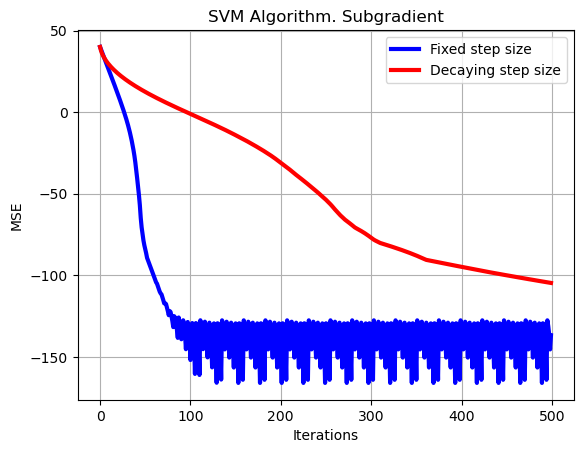

In [17]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_subgrad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3, label = 'Fixed step size')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_subgrad_decay-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3, label = 'Decaying step size')
#for k in range(set_up['Number_tests']):
#    plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_inst[k,:]-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),linestyle='dotted',color='b', linewidth = 3)
#    plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_inst_decay[k,:]-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),linestyle='dotted',color='r', linewidth = 3),
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.title('SVM Algorithm. Subgradient')
plt.show()